First the necessary python packages are imported

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

### Random Seed
Fix the numpy random seed for repeatable results.

In [2]:
np.random.seed(42)

Define a helper functions below

In [3]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    
    Adapted from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Arguments:
        y_true: Real class labels.
        y_pred: Predicted class labels.
        classes: List of class names.
        title: Title for the plot.
        cmap: Colormap to be used.
    
    Returns:
        None.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()
    
def plot_3d_event(dataset,
                  labels,
                  idx):
    
    """This function plots a single event in a 3d plot
    with x,y,z for each pad fired
    dataset = AllData (unless you create different list)
    labels = Labels (used for setting beam or reaction in title)
    idx = index of event in dataset
    """
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    xvalues = np.zeros(len(dataset[idx]))
    yvalues = np.zeros(len(dataset[idx]))
    zvalues = np.zeros(len(dataset[idx]))
    
    for i in range(len(dataset[idx])):
        xvalues[i] = dataset[idx][i][0]
        yvalues[i] = dataset[idx][i][1]
        zvalues[i] = dataset[idx][i][2]
    
    
    ax.scatter(xvalues, yvalues, zvalues, marker='o')
    if (labels[idx]==0):
        ax.set_title('Beam Event')
    else:
        ax.set_title('Reaction Event')
    
    ax.set_xlabel('X[mm]')
    ax.set_ylabel('Y[mm]')
    ax.set_zlabel('Z[mm]')
    plt.show()

Now the dataset is loaded.
Default location (for me) is in DataFiles folder (located in current directory) 

So file path is ./DataFiles/Mg22_alphaalpha_digiSim.h5

In [28]:
#URL for downloading from the Machine Learning ECT github (somehow does not work)
#f.close()
#data_origin_MLECT = 'https://github.com/NuclearTalent/MachineLearningECT/raw/master/doc/ProjectsExercises/2020/ProjectAT/pdf/Mg22_alphaalpha_digiSim.h5'
#MLECT_path = tf.keras.utils.get_file('Mg22_alphaalpha_digiSim.h5', origin=data_origin_MLECT)
#f=h5py.File(MLECT_path, 'r') 

OSError: Unable to open file (file signature not found)

In [5]:
#Open the local file
local_data='./DataFiles/Mg22_alphaalpha_digiSim.h5'
f=h5py.File(local_data, 'r')
#print(f.keys())
print(f['Event_[0]'])
#AllEvents = np.zeros (len(f.keys()))
   

<HDF5 dataset "Event_[0]": shape (24,), type "|V48">


Now we load the data into a simple list. This list has three indices [event number][pad fired][data column]

with event number in [0,1999], pad fired in [0,x] with x variable for each event, data column in [0,5] (x,y,z,T,A,zeros)


In [6]:
AllDataList = []
for i in range(len(f.keys())):
    KeyString = "Event_[" + str(i) +"]"
    AllDataList.append(f[KeyString][:])

print(AllDataList[0])
print(f["Event_[0]"][0])
print(AllDataList[0][0])
print("Dataset contains " + str(len(AllDataList)) + " events")


[(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0)
 (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0)
 (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0)
 ( 2.45413303e+00, -1.45075214, 900., 450, 3.77884522e+03, 0)
 (-1.33514404e-05, -2.79990482, 900., 450, 1.13686783e+04, 0)
 ( 2.45413303e+00,  1.45075214, 962., 481, 3.21076480e+03, 0)
 ( 4.90825081e+00, -5.70140886, 964., 482, 4.45706507e+01, 0)
 ( 2.45410442e+00,  7.05056143, 966., 483, 2.11128009e+01, 0)
 (-2.45413113e+00, -7.05056143, 984., 492, 1.90553867e+01, 0)
 (-4.90824747e+00,  5.70140886, 986., 493, 1.97473273e+01, 0)
 ( 4.90825081e+00,  5.70140886, 986., 493, 2.12675051e+01, 0)
 (-4.90824747e+00,  2.79990482, 990., 495, 4.76823698e+01, 0)
 (-4.90824747e+00, -5.70140886, 990., 495, 2.12226325e+01, 0)
 (-4.90824747e+00, -2.79990482, 990., 495, 2.63826991e+02, 0)
 ( 4.90825081e+00,  2.79990482, 990., 495, 4.01348998e+02, 0)
 (-2.45413113e+00,  7.05056143, 990., 495, 2.26033067e+01, 0)
 (-1.335

The last data column contains only zeroes and can be removed to reduce data size

 ### Labeling and cleaning
 The events came labeled, with even nr events = reaction (label 1), odd nr events = beam (label 0)
 
 We also remove empty events (384, 430,484,914,1204 (numbers correspond to keys))
 
Before moving on we label the data and then split it into training, validation and test (only generating indices)
We also remove the empty events and label thes correctly

In [7]:

LabelsList = []
AllData = []
for i in range(len(AllDataList)):
    if (len(AllDataList[i])>0):
        AllData.append(AllDataList[i])
        if (i%2==0):
            LabelsList.append(1)
        else:
            LabelsList.append(0)

 

Labels = np.array(LabelsList)

    
print(Labels)
print("Dataset contains " + str(len(AllData)) + " non-empty events")

x_idx = np.arange(len(AllData))
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)
print("Dataset was divided into " + str(len(train_idx)) + " training events, " + str(len(val_idx)) + " validation events and " + str(len(test_idx)) + " test events")
    

[1 0 1 ... 0 1 0]
Dataset contains 1995 non-empty events
Dataset was divided into 1615 training events, 180 validation events and 200 test events


### Raw event visualization
We plot a few events using the helper function plot_3d_event to get an idea of beam and reaction events.

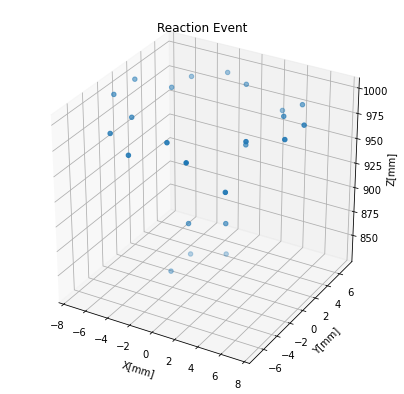

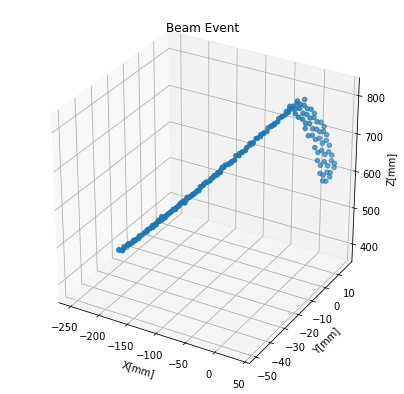

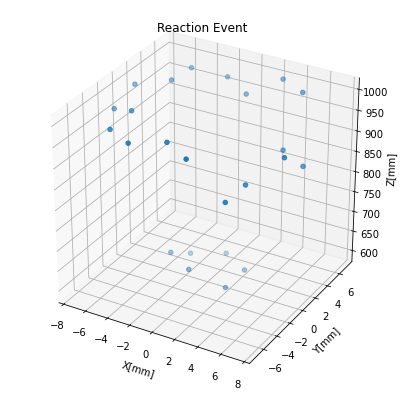

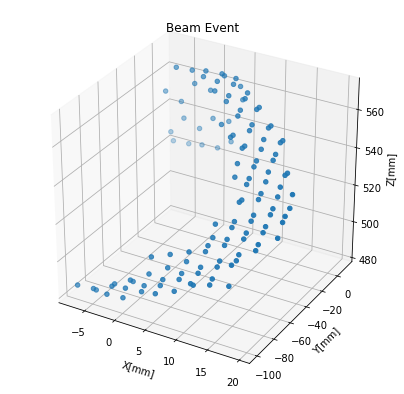

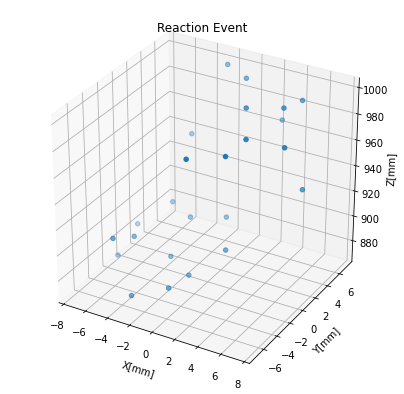

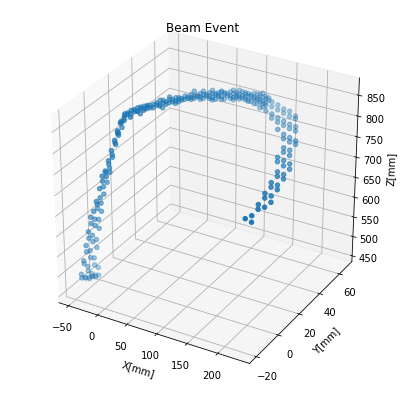

In [8]:
plot_3d_event(AllData,Labels,0)
plot_3d_event(AllData,Labels,1)
plot_3d_event(AllData,Labels,2)
plot_3d_event(AllData,Labels,3)
plot_3d_event(AllData,Labels,4)
plot_3d_event(AllData,Labels,5)


### Simple Characteristics
Now let's try to visualize simple characteristics, average x, average y, average z and sum of A for each event
Also number of pads fired per event

2nd version: replacing average x, average y by standard deviation x, standard deviation y. 

In [9]:
MeanXPerEvent = np.zeros(len(AllData))
MeanYPerEvent = np.zeros(len(AllData))
MeanZPerEvent = np.zeros(len(AllData))
SumAPerEvent = np.zeros(len(AllData))
PadsPerEvent = np.zeros(len(AllData))
MeanWeightedXPerEvent = np.zeros(len(AllData))
MeanWeightedYPerEvent = np.zeros(len(AllData))
StDevXPerEvent = np.zeros(len(AllData))
StDevYPerEvent = np.zeros(len(AllData))
StDevZPerEvent = np.zeros(len(AllData))



for i in range(len(AllData)):

    for j in range(len(AllData[i])):
        MeanXPerEvent[i] = MeanXPerEvent[i] + AllData[i][j][0]
        MeanYPerEvent[i] = MeanYPerEvent[i] + AllData[i][j][1]
        MeanZPerEvent[i] = MeanZPerEvent[i] + AllData[i][j][2]
        SumAPerEvent[i] = SumAPerEvent[i] + AllData[i][j][4]
        MeanWeightedXPerEvent[i] = MeanWeightedXPerEvent[i] + AllData[i][j][0]*AllData[i][j][4]
        MeanWeightedYPerEvent[i] = MeanWeightedYPerEvent[i] + AllData[i][j][1]*AllData[i][j][4]
    
    MeanXPerEvent[i] = MeanXPerEvent[i]/len(AllData[i])
    MeanYPerEvent[i] = MeanYPerEvent[i]/len(AllData[i])
    MeanZPerEvent[i] = MeanZPerEvent[i]/len(AllData[i])
    MeanWeightedXPerEvent[i] = MeanWeightedXPerEvent[i]/len(AllData[i])
    MeanWeightedYPerEvent[i] = MeanWeightedYPerEvent[i]/len(AllData[i])
    
    #second for loop for calculation of standard deviation
    for j in range(len(AllData[i])):
        StDevXPerEvent[i] = StDevXPerEvent[i] + (AllData[i][j][0]-MeanXPerEvent[i])**2
        StDevYPerEvent[i] = StDevYPerEvent[i] + (AllData[i][j][1]-MeanYPerEvent[i])**2
        StDevZPerEvent[i] = StDevZPerEvent[i] + (AllData[i][j][2]-MeanZPerEvent[i])**2
   
    StDevXPerEvent[i] = np.sqrt(StDevXPerEvent[i])/(len(AllData[i])-1)
    StDevYPerEvent[i] = np.sqrt(StDevYPerEvent[i])/(len(AllData[i])-1)
    StDevZPerEvent[i] = np.sqrt(StDevZPerEvent[i])/(len(AllData[i])-1)
    
    
        
    
    
    PadsPerEvent[i] = len(AllData[i])
    
print(SumAPerEvent)
print(MeanXPerEvent)      

[ 41292.86413493 322786.82279782  89094.2067578  ...  37851.88599835
  45542.97047786 260079.24714189]
[-3.33786011e-06 -6.60346445e+01 -3.33786011e-06 ... -4.39459217e+00
 -3.33786011e-06 -4.74462833e+00]


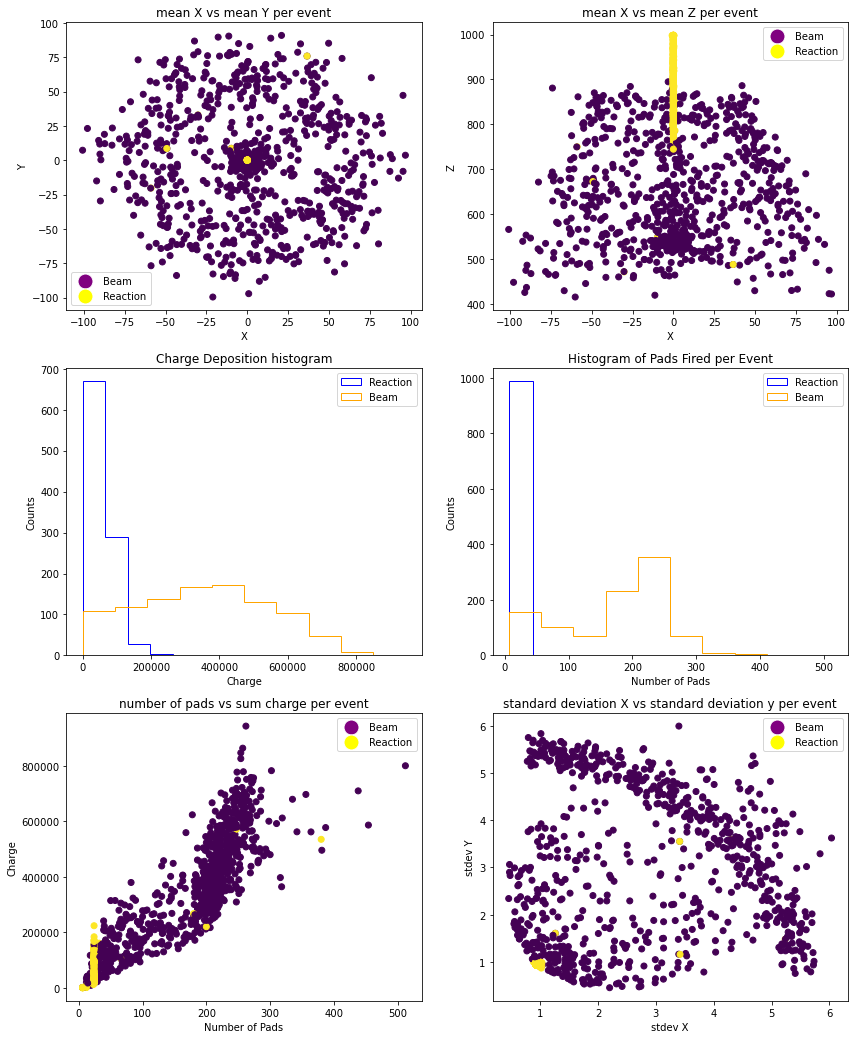

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(14, 18))

#define legend for 2d plots
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Beam', markerfacecolor='purple', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Reaction', markerfacecolor='yellow', markersize=15)]

ax[0][0].scatter(MeanXPerEvent[train_idx],MeanYPerEvent[train_idx], c = Labels[train_idx])
ax[0][0].set_title("mean X vs mean Y per event")
ax[0][0].set_xlabel("X")
ax[0][0].set_ylabel("Y")
ax[0][0].legend(handles=legend_elements)

ax[0][1].scatter(MeanXPerEvent[train_idx],MeanZPerEvent[train_idx], c = Labels[train_idx])
ax[0][1].set_title("mean X vs mean Z per event")
ax[0][1].set_xlabel("X")
ax[0][1].set_ylabel("Z")
ax[0][1].legend(handles=legend_elements)

ax[1][0].hist(SumAPerEvent[Labels>0.5], color='blue', label = 'Reaction', histtype = 'step')
ax[1][0].hist(SumAPerEvent[Labels<0.5], color='orange', label = 'Beam', histtype = 'step')
ax[1][0].set_title("Charge Deposition histogram")
ax[1][0].set_xlabel("Charge")
ax[1][0].set_ylabel("Counts")
ax[1][0].legend()

ax[1][1].hist(PadsPerEvent[Labels>0.5], color='blue', label = 'Reaction', histtype = 'step')
ax[1][1].hist(PadsPerEvent[Labels<0.5], color='orange', label = 'Beam', histtype = 'step')
ax[1][1].set_title("Histogram of Pads Fired per Event")
ax[1][1].set_xlabel("Number of Pads")
ax[1][1].set_ylabel("Counts")
ax[1][1].legend()

ax[2][0].scatter(PadsPerEvent[train_idx],SumAPerEvent[train_idx], c = Labels[train_idx])
ax[2][0].set_title("number of pads vs sum charge per event")
ax[2][0].set_xlabel("Number of Pads")
ax[2][0].set_ylabel("Charge")
ax[2][0].legend(handles=legend_elements)



ax[2][1].scatter(StDevXPerEvent[train_idx],StDevYPerEvent[train_idx], c = Labels[train_idx])
ax[2][1].set_title("standard deviation X vs standard deviation y per event")
ax[2][1].set_xlabel("stdev X")
ax[2][1].set_ylabel("stdev Y")
ax[2][1].legend(handles=legend_elements)









### Visualizing the outliers

Looking at the previous plots, one notes a few reaction events that behave very much as beam events
We find and plot them here

[1711, 499, 280, 1098]


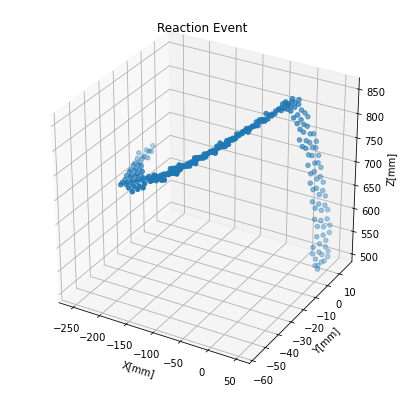

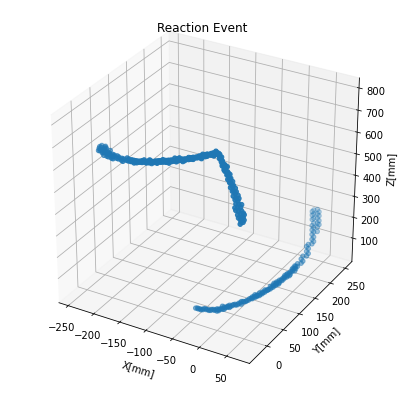

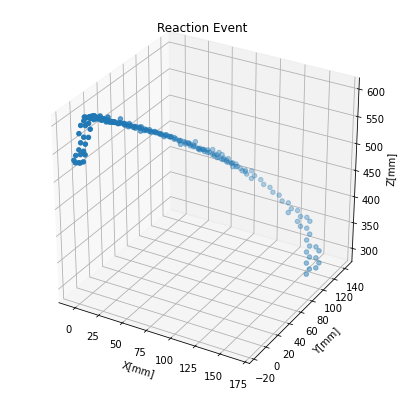

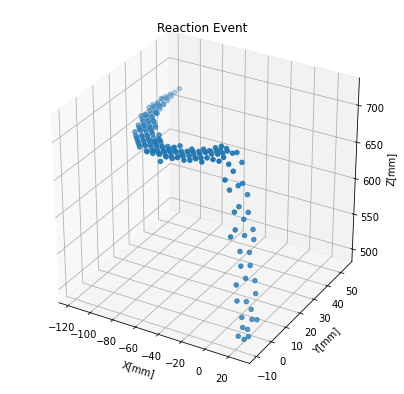

In [11]:
large_x_stdev = train_idx[StDevXPerEvent[train_idx]>3]
Outliers = []
for i in range(len(large_x_stdev)):
    if (Labels[large_x_stdev[i]]==1):
        Outliers.append(large_x_stdev[i])

print(Outliers)
for i in range(len(Outliers)):
    plot_3d_event(AllData,Labels,Outliers[i])

    


### Merging
Now we merge these data into features and labels.

In [12]:
xSimple = np.zeros((len(AllData),5))

for i in range(len(AllData)):
    #standard x and y
    #xSimple[i][0] = MeanXPerEvent[i]
    xSimple[i][1] = MeanYPerEvent[i]
    #alternative x and y
    xSimple[i][0] = StDevXPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    xSimple[i][2] = MeanZPerEvent[i]
    xSimple[i][3] = SumAPerEvent[i]
    xSimple[i][4] = PadsPerEvent[i]

xSimple_train = xSimple[train_idx][:]
xSimple_val = xSimple[val_idx][:]
xSimple_test = xSimple[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val = Labels[val_idx]
Labels_test = Labels[test_idx]

#ar_nan = np.where(np.isnan(xSimple))
#print (ar_nan)
#ar_inf = np.where(np.isinf(xSimple))
#print (ar_inf)
#ar_neginf = np.where(np.isneginf(xSimple))
#print (ar_neginf)

print(xSimple[1204,:])


[ 7.22232394e-01 -8.01214222e+00  6.32156250e+02  1.72528081e+05
  6.40000000e+01]


### Logistic Regression
Now let us try a few simple models on the parameters obtained above. We start with a logistic regression model, as imported from sklearn.

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(xSimple_train, Labels_train)
print("validation set accuracy: {:.3f}".format(logreg.score(xSimple_val,Labels_val)))

validation set accuracy: 0.967


Another try using StandardScaler to get scaled data.

validation set accuracy: 0.994
Confusion matrix for training set:



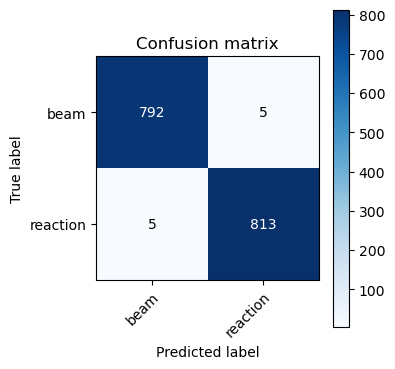

Accuracy: 0.9938080495356038
F1-score: 0.9938875305623472
MCC: 0.9876140048408917
Confusion matrix for validation set:



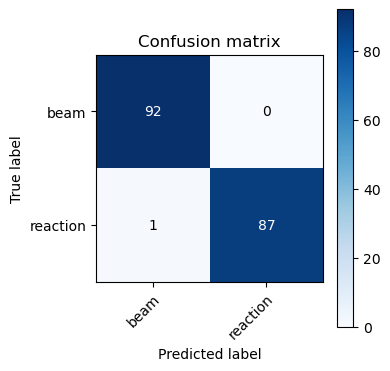

Accuracy: 0.9944444444444445
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(xSimple_train)
xSimple_train_stsc = scaler.transform(xSimple_train)
xSimple_val_stsc = scaler.transform(xSimple_val)
logreg2 = LogisticRegression()
logreg2.fit(xSimple_train_stsc, Labels_train)
print("validation set accuracy: {:.3f}".format(logreg2.score(xSimple_val_stsc,Labels_val)))

LR_pred_train = logreg2.predict(xSimple_train_stsc)
LR_pred_val = logreg2.predict(xSimple_val_stsc)

accuracy = accuracy_score(Labels_val, LR_pred_val)
confmat = confusion_matrix(Labels_val, LR_pred_val)
f1 = f1_score(Labels_val, LR_pred_val)
mcc = matthews_corrcoef(Labels_val, LR_pred_val)

accuracy_train = accuracy_score(Labels_train, LR_pred_train)
confmat_train = confusion_matrix(Labels_train, LR_pred_train)
f1_train = f1_score(Labels_train, LR_pred_train)
mcc_train = matthews_corrcoef(Labels_train, LR_pred_train)

print("Confusion matrix for training set:\n")
plot_confusion_matrix(Labels_train, LR_pred_train, ["beam","reaction"])
print("Accuracy:", accuracy_train)
print("F1-score:", f1_train)
print("MCC:", mcc_train)


print("Confusion matrix for validation set:\n")
plot_confusion_matrix(Labels_val, LR_pred_val, ["beam","reaction"])
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("MCC:", mcc)

### Random Forest
Here a random forest is used for classification. Grid search is used for optimisation of the parameters

{'bootstrap': False, 'max_features': 3, 'n_estimators': 6}
RandomForestClassifier(bootstrap=False, max_features=3, n_estimators=6)
[(0.6100065138426493, 'nrofpads'), (0.1573830501781962, 'x'), (0.12463607827399338, 'charge'), (0.09885231581202891, 'z'), (0.009122041893132206, 'y')]
Confusion matrix for training set:



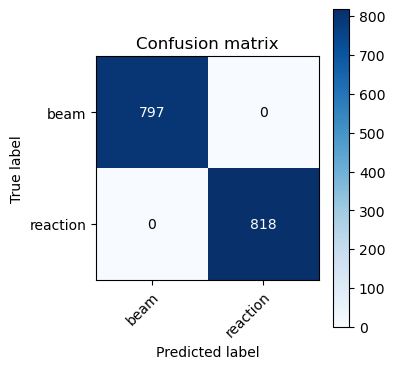

Accuracy: 1.0
F1-score: 1.0
MCC: 1.0
[1 0 1 ... 1 0 1]
Confusion matrix for validation set:



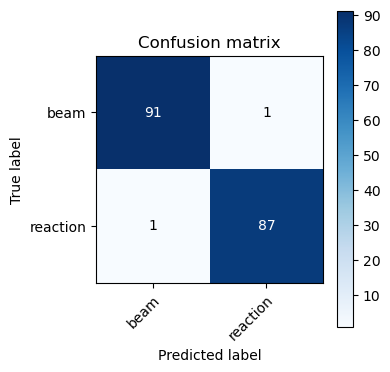

Accuracy: 0.9888888888888889
F1-score: 0.9886363636363636
MCC: 0.9777667984189723


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#RFC = RandomForestClassifier()
#RFC.fit(xSimple_train_stsc, Labels_train)

#RFC_pred_train = RFC.predict(xSimple_train_stsc)
#RFC_mse_train = mean_squared_error(Labels_train, RFC_pred_train)
#RFC_rmse_train = np.sqrt(RFC_mse_train)
#print('random forest rmse of training data is: ', RFC_rmse_train)

#scores = cross_val_score(RFC, xSimple_train_stsc, Labels_train, scoring="neg_mean_squared_error", cv=10)
#RFC_scores = np.sqrt(-scores)
#display_scores(RFC_scores)


param_grid = [
{'n_estimators': [3, 4,5,6], 'max_features': [2,3,4,5], 'bootstrap': [False,True]},
]
RFC = RandomForestClassifier()
grid_search_imp = GridSearchCV(RFC, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_imp.fit(xSimple_train_stsc, Labels_train)
print(grid_search_imp.best_params_)
print(grid_search_imp.best_estimator_)

cvres = grid_search_imp.cv_results_
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    #print(np.sqrt(-mean_score), params)

feature_importances = grid_search_imp.best_estimator_.feature_importances_
print(sorted(zip(feature_importances, ["x","y","z","charge","nrofpads"]), reverse=True))

RFC_best = grid_search_imp.best_estimator_
RFC_pred_train = RFC_best.predict(xSimple_train_stsc)
RFC_pred_val = RFC_best.predict(xSimple_val_stsc)
#forest_mse_imp_final = mean_squared_error(trdata_labels, deaths_predictions_forest_final)
#forest_rmse_imp_final = np.sqrt(forest_mse_imp_final)
#print('random forest rmse (final version) of training data is: ', forest_rmse_imp)

accuracy = accuracy_score(Labels_val, RFC_pred_val)
confmat = confusion_matrix(Labels_val, RFC_pred_val)
f1 = f1_score(Labels_val, RFC_pred_val)
mcc = matthews_corrcoef(Labels_val, RFC_pred_val)

accuracy_train = accuracy_score(Labels_train, RFC_pred_train)
confmat_train = confusion_matrix(Labels_train, RFC_pred_train)
f1_train = f1_score(Labels_train, RFC_pred_train)
mcc_train = matthews_corrcoef(Labels_train, RFC_pred_train)

print("Confusion matrix for training set:\n")
plot_confusion_matrix(Labels_train, RFC_pred_train, ["beam","reaction"])
print("Accuracy:", accuracy_train)
print("F1-score:", f1_train)
print("MCC:", mcc_train)
print(RFC_pred_train)

print("Confusion matrix for validation set:\n")
plot_confusion_matrix(Labels_val, RFC_pred_val, ["beam","reaction"])
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("MCC:", mcc)
#print(RFC_pred_val)

### Dense Neural Network
Now we try a dense neural network on these simple features

In [16]:
# Init the Sequential model
model = tf.keras.Sequential()
# Add Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(xSimple_train_stsc.shape[1],)))

# Add hidden layer
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))


# Add output layer.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Finally, compile the model and print a summary. Loss function and optimizer is set during compilation.
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,089
Trainable params: 8,961
Non-trainable params: 128
_________________________________________________________________


#### Training DNN
Now we train the neural network


In [17]:
# Set parameters for the training run. The full data set is only 2000x5 doubles so large nr of epochs and
# small batch_size will still work well even on cpu
epochs = 20
batch_size = 16

Now the DNN is trained using the standardscaled data.

In [18]:
# The validation_data keywork expects a 'tuple' (val_x, val_y) so we make one on the fly
history = model.fit(
    x=xSimple_train_stsc,
    y=Labels_train,
    validation_data=(xSimple_val_stsc, Labels_val),
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/20
101/101 [==============================] - 1s 12ms/step - loss: 0.1005 - accuracy: 0.9721 - val_loss: 0.1747 - val_accuracy: 0.9944
Epoch 2/20
101/101 [==============================] - 1s 8ms/step - loss: 0.0373 - accuracy: 0.9926 - val_loss: 0.0809 - val_accuracy: 0.9944
Epoch 3/20
101/101 [==============================] - 1s 8ms/step - loss: 0.0365 - accuracy: 0.9913 - val_loss: 0.0441 - val_accuracy: 0.9944
Epoch 4/20
101/101 [==============================] - 1s 8ms/step - loss: 0.0321 - accuracy: 0.9938 - val_loss: 0.0373 - val_accuracy: 0.9944
Epoch 5/20
101/101 [==============================] - 1s 8ms/step - loss: 0.0232 - accuracy: 0.9963 - val_loss: 0.0313 - val_accuracy: 0.9944
Epoch 6/20
101/101 [==============================] - 1s 8ms/step - loss: 0.0290 - accuracy: 0.9950 - val_loss: 0.0329 - val_accuracy: 0.9944
Epoch 7/20
101/101 [==============================] - 1s 8ms/step - loss: 0.0257 - accuracy: 0.9957 - val_loss: 0.0318 - val_accuracy: 0.9944
Epoch

#### Visualisation of results

Confusion matrix for training set:



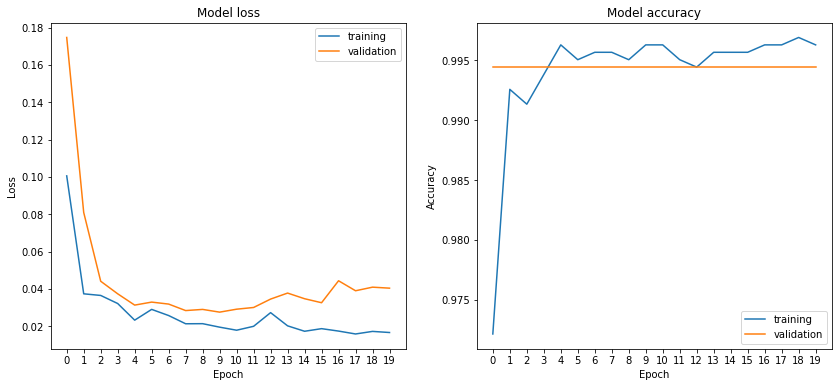

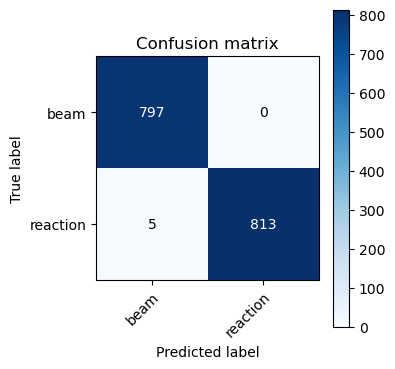

Accuracy: 0.9969040247678018
F1-score: 0.996934396076027
MCC: 0.9938265564282749
[1 0 1 ... 1 0 1]
Confusion matrix for validation set:



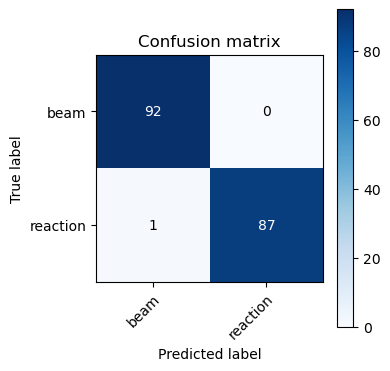

Accuracy: 0.9944444444444445
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


In [19]:
# Plot loss and val_loss as one plot, and accuracy and val_accuracy as another, side-by-side.
# We'll also save this plot as plot_history() in the helper_functions file, so any time we need to
# plot the history object like this we can just call that function and pass the history object as
# an argument.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
num_epochs = len(history.history['loss'])
ax[0].plot(history.history['loss'], label='training')
ax[0].plot(history.history['val_loss'], label='validation')
#ax[0].plot(history2.history['loss'], label='training my method')
#ax[0].plot(history2.history['val_loss'], label='validation my method')
ax[0].set_title("Model loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_xticks(np.arange(num_epochs))
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='training')
ax[1].plot(history.history['val_accuracy'], label='validation')
#ax[1].plot(history2.history['accuracy'], label='training my method')
#ax[1].plot(history2.history['val_accuracy'], label='validation my method')
ax[1].set_title("Model accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_xticks(np.arange(num_epochs))
ax[1].legend()

#the _pre contain a number in [0,1] these get mapped to 1 if >0.5 and to 0 if <0.5
DNN_pred_train_pre = model.predict(xSimple_train_stsc)
DNN_pred_val_pre = model.predict(xSimple_val_stsc)
DNN_pred_train = DNN_pred_train_pre > 0.5
DNN_pred_val = DNN_pred_val_pre > 0.5


accuracy_train = accuracy_score(Labels_train, DNN_pred_train)
confmat_train = confusion_matrix(Labels_train, DNN_pred_train)
f1_train = f1_score(Labels_train, DNN_pred_train)
mcc_train = matthews_corrcoef(Labels_train, DNN_pred_train)

accuracy = accuracy_score(Labels_val, DNN_pred_val)
confmat = confusion_matrix(Labels_val, DNN_pred_val)
f1 = f1_score(Labels_val, DNN_pred_val)
mcc = matthews_corrcoef(Labels_val, DNN_pred_val)

print("Confusion matrix for training set:\n")
plot_confusion_matrix(Labels_train, DNN_pred_train, ["beam","reaction"])
print("Accuracy:", accuracy_train)
print("F1-score:", f1_train)
print("MCC:", mcc_train)
print(RFC_pred_train)

print("Confusion matrix for validation set:\n")
plot_confusion_matrix(Labels_val, DNN_pred_val, ["beam","reaction"])
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("MCC:", mcc)


### K-Means
Here we try k-means to separate beam from reaction events

[0 1 0 ... 0 1 0]
Confusion matrix for training set:



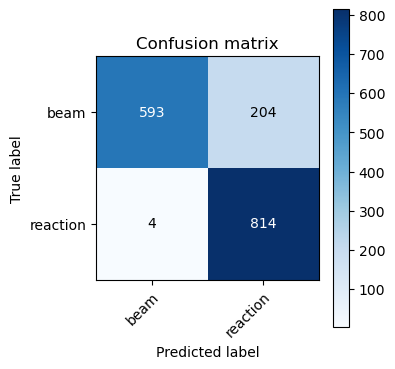

Accuracy: 0.8712074303405573
F1-score: 0.886710239651416
MCC: 0.7655568416123274
Confusion matrix for validation set:



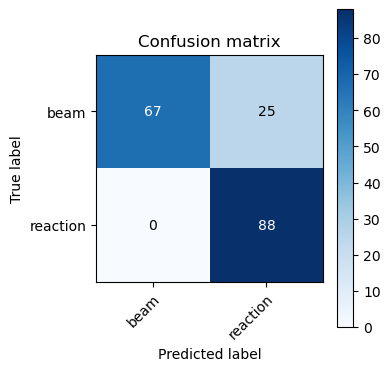

Accuracy: 0.8611111111111112
F1-score: 0.8756218905472637
MCC: 0.7530877825041271


In [20]:
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=2).fit(xSimple_train_stsc)
print(clust.labels_)
KM_pred_train = clust.predict(xSimple_train_stsc)
KM_pred_val = clust.predict(xSimple_val_stsc)

#Now we need to find out which cluster is which type of event
#We select the one that gives best accuracy on training set

accuracy_train_norm = accuracy_score(Labels_train, KM_pred_train)
accuracy_train_swap = accuracy_score(Labels_train, 1-KM_pred_train)

if(accuracy_train_swap>accuracy_train_norm):
    KM_pred_train = 1- KM_pred_train
    KM_pred_val = 1 - KM_pred_val

accuracy_train = accuracy_score(Labels_train, KM_pred_train)
confmat_train = confusion_matrix(Labels_train, KM_pred_train)
f1_train = f1_score(Labels_train, KM_pred_train)
mcc_train = matthews_corrcoef(Labels_train, KM_pred_train)

accuracy = accuracy_score(Labels_val, KM_pred_val)
confmat = confusion_matrix(Labels_val, KM_pred_val)
f1 = f1_score(Labels_val, KM_pred_val)
mcc = matthews_corrcoef(Labels_val, KM_pred_val)

print("Confusion matrix for training set:\n")
plot_confusion_matrix(Labels_train, KM_pred_train, ["beam","reaction"])
print("Accuracy:", accuracy_train)
print("F1-score:", f1_train)
print("MCC:", mcc_train)

print("Confusion matrix for validation set:\n")
plot_confusion_matrix(Labels_val, KM_pred_val, ["beam","reaction"])
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("MCC:", mcc)


#### Elbow method for K-Means
Here we look for the optimal number of clusters for kmeans. Even with more clusters than our (2) available classes
we can still assign them each to 1 or 0 based on which mapping gives the best results.

Based on [Geron notebook](https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb)
        (search for 'finding the optimal number of clusters')

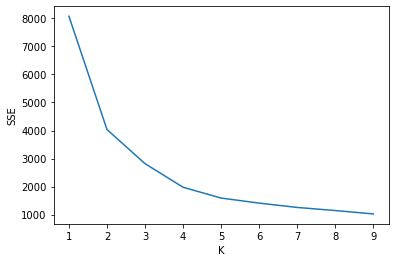

In [21]:
k_rng = range(1,10)
sse = []

for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(xSimple_train_stsc)
    sse.append(km.inertia_)

sse
plt.xlabel('K')
plt.ylabel('SSE') #sum of squared error

plt.plot(k_rng,sse)



Based on shoulder method we can use 3 or 5 clusters as well.
Let us try both cases. 
First 3 clusters case.
#### 3-Cluster K-Means 

[1 0 1 ... 1 2 1]
[0.3058823529411765, 0.8705882352941177, 0.6829721362229102, 0.3170278637770898, 0.12941176470588237, 0.6941176470588235]
Confusion matrix for training set:



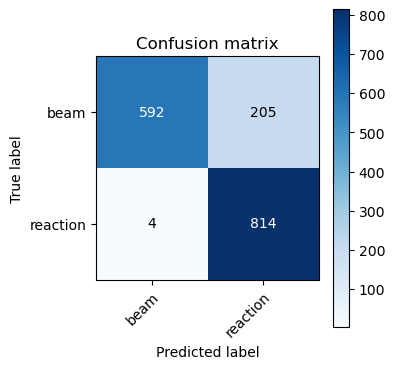

Accuracy: 0.8705882352941177
F1-score: 0.8862275449101797
MCC: 0.7645227877985111
Confusion matrix for validation set:



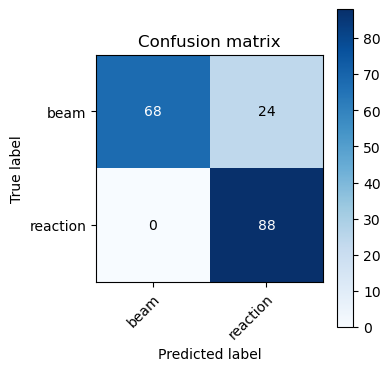

Accuracy: 0.8666666666666667
F1-score: 0.88
MCC: 0.7620664942214077


In [22]:
nclusters = 3
clust3 = KMeans(n_clusters=nclusters).fit(xSimple_train_stsc)
print(clust3.labels_)
KM3_pred_train = clust3.predict(xSimple_train_stsc)
KM3_pred_val = clust3.predict(xSimple_val_stsc)

#Now we need to find out which cluster is which type of event
#We select the one that gives best accuracy on training set
#for this we loop over all combinations without trivial ones (all beam or all reaction)
#we denote accuracy_train_010 if cluster 0->0, 1->1 and 2->0

KM3_pred_train_001 = np.zeros(len(KM3_pred_train))
KM3_pred_train_010 = np.zeros(len(KM3_pred_train))
KM3_pred_train_011 = np.zeros(len(KM3_pred_train))
KM3_pred_train_100 = np.zeros(len(KM3_pred_train))
KM3_pred_train_101 = np.zeros(len(KM3_pred_train))
KM3_pred_train_110 = np.zeros(len(KM3_pred_train))
KM3_pred_val_001 = np.zeros(len(KM3_pred_val))
KM3_pred_val_010 = np.zeros(len(KM3_pred_val))
KM3_pred_val_011 = np.zeros(len(KM3_pred_val))
KM3_pred_val_100 = np.zeros(len(KM3_pred_val))
KM3_pred_val_101 = np.zeros(len(KM3_pred_val))
KM3_pred_val_110 = np.zeros(len(KM3_pred_val))

for i in range(len(KM3_pred_train)):
    if (KM3_pred_train[i]==0):
        KM3_pred_train_001[i] = 0
        KM3_pred_train_010[i] = 0
        KM3_pred_train_011[i] = 0
        KM3_pred_train_100[i] = 1
        KM3_pred_train_101[i] = 1
        KM3_pred_train_110[i] = 1
    if (KM3_pred_train[i]==1):
        KM3_pred_train_001[i] = 0
        KM3_pred_train_010[i] = 1
        KM3_pred_train_011[i] = 1
        KM3_pred_train_100[i] = 0
        KM3_pred_train_101[i] = 0
        KM3_pred_train_110[i] = 1
    if (KM3_pred_train[i]==2):
        KM3_pred_train_001[i] = 1
        KM3_pred_train_010[i] = 0
        KM3_pred_train_011[i] = 1
        KM3_pred_train_100[i] = 0
        KM3_pred_train_101[i] = 1
        KM3_pred_train_110[i] = 0
        
for i in range(len(KM3_pred_val)):
    if (KM3_pred_val[i]==0):
        KM3_pred_val_001[i] = 0
        KM3_pred_val_010[i] = 0
        KM3_pred_val_011[i] = 0
        KM3_pred_val_100[i] = 1
        KM3_pred_val_101[i] = 1
        KM3_pred_val_110[i] = 1
    if (KM3_pred_val[i]==1):
        KM3_pred_val_001[i] = 0
        KM3_pred_val_010[i] = 1
        KM3_pred_val_011[i] = 1
        KM3_pred_val_100[i] = 0
        KM3_pred_val_101[i] = 0
        KM3_pred_val_110[i] = 1
    if (KM3_pred_val[i]==2):
        KM3_pred_val_001[i] = 1
        KM3_pred_val_010[i] = 0
        KM3_pred_val_011[i] = 1
        KM3_pred_val_100[i] = 0
        KM3_pred_val_101[i] = 1
        KM3_pred_val_110[i] = 0

        
        

accuracy_train_001 = accuracy_score(Labels_train, KM3_pred_train_001)
accuracy_train_010 = accuracy_score(Labels_train, KM3_pred_train_010)
accuracy_train_011 = accuracy_score(Labels_train, KM3_pred_train_011)
accuracy_train_100 = accuracy_score(Labels_train, KM3_pred_train_100)
accuracy_train_101 = accuracy_score(Labels_train, KM3_pred_train_101)
accuracy_train_110 = accuracy_score(Labels_train, KM3_pred_train_110)

KM3_tr_acc_list = [accuracy_train_001, accuracy_train_010, accuracy_train_011, accuracy_train_100, 
                   accuracy_train_101, accuracy_train_110]
print(KM3_tr_acc_list)

#Finds best accuracy model
max_accuracy_KM3_train = max(KM3_tr_acc_list)
max_index_KM3 = KM3_tr_acc_list.index(max_accuracy_KM3_train)

if (max_index_KM3==0):
    KM3_pred_train = KM3_pred_train_001
    KM3_pred_val = KM3_pred_val_001
elif (max_index_KM3==1):
    KM3_pred_train = KM3_pred_train_010
    KM3_pred_val = KM3_pred_val_010
elif (max_index_KM3==2):
    KM3_pred_train = KM3_pred_train_011
    KM3_pred_val = KM3_pred_val_011
elif (max_index_KM3==3):
    KM3_pred_train = KM3_pred_train_100
    KM3_pred_val = KM3_pred_val_100
elif (max_index_KM3==4):
    KM3_pred_train = KM3_pred_train_101
    KM3_pred_val = KM3_pred_val_101
elif (max_index_KM3==5):
    KM3_pred_train = KM3_pred_train_110
    KM3_pred_val = KM3_pred_val_110
    

accuracy_train = accuracy_score(Labels_train, KM3_pred_train)
confmat_train = confusion_matrix(Labels_train, KM3_pred_train)
f1_train = f1_score(Labels_train, KM3_pred_train)
mcc_train = matthews_corrcoef(Labels_train, KM3_pred_train)

accuracy = accuracy_score(Labels_val, KM3_pred_val)
confmat = confusion_matrix(Labels_val, KM3_pred_val)
f1 = f1_score(Labels_val, KM3_pred_val)
mcc = matthews_corrcoef(Labels_val, KM3_pred_val)

print("Confusion matrix for training set:\n")
plot_confusion_matrix(Labels_train, KM3_pred_train, ["beam","reaction"])
print("Accuracy:", accuracy_train)
print("F1-score:", f1_train)
print("MCC:", mcc_train)

print("Confusion matrix for validation set:\n")
plot_confusion_matrix(Labels_val, KM3_pred_val, ["beam","reaction"])
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("MCC:", mcc)

#### 3-Cluster K-Means 
and now for 5 clusters

[4 3 4 ... 4 3 4]
[0.9913312693498452, 0.37275541795665634, 0.8705882352941177, 0.3931888544891641, 0.8910216718266254, 0.2724458204334365, 0.7702786377708978, 0.3814241486068111, 0.8792569659442725, 0.2606811145510836, 0.7585139318885449, 0.28111455108359135, 0.7789473684210526, 0.16037151702786379, 0.6582043343653251, 0.34179566563467495, 0.8396284829721362, 0.22105263157894736, 0.7188854489164087, 0.24148606811145512, 0.7393188854489164, 0.12074303405572756, 0.6185758513931888, 0.22972136222910217, 0.7275541795665634, 0.10897832817337462, 0.6068111455108359, 0.12941176470588237, 0.6272445820433437, 0.0086687306501548]
Confusion matrix for training set:



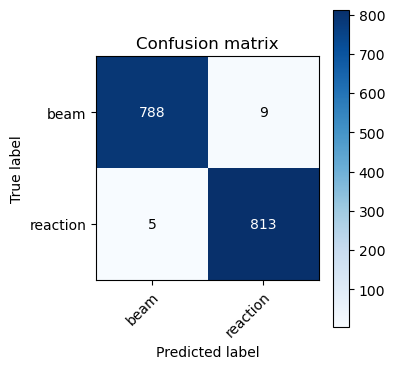

Accuracy: 0.9913312693498452
F1-score: 0.9914634146341463
MCC: 0.9826705515668984
Confusion matrix for validation set:



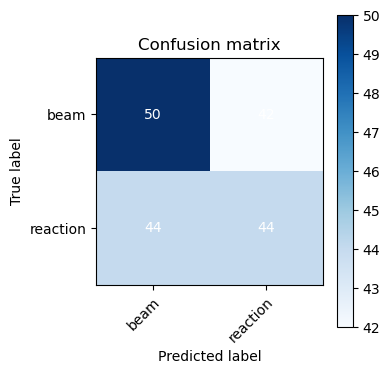

Accuracy: 0.5222222222222223
F1-score: 0.5057471264367817
MCC: 0.04351051876508937
[[50 42]
 [44 44]]


In [23]:
nclusters = 5
clust5 = KMeans(n_clusters=nclusters).fit(xSimple_train_stsc)
print(clust5.labels_)
KM5_pred_train = clust5.predict(xSimple_train_stsc)
KM5_pred_val = clust5.predict(xSimple_val_stsc)

#Now we need to find out which cluster is which type of event
#We select the one that gives best accuracy on training set
#for this we loop over all combinations without trivial ones (all beam or all reaction)
#we denote accuracy_train_01010 if cluster 0->0, 1->1, 2->0, 3->1 and 4->1

KM5_pred_train_00001 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00010 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00011 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00100 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00101 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00110 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00111 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01000 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01001 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01010 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01011 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01100 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01101 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01110 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01111 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10000 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10001 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10010 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10011 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10100 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10101 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10110 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10111 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11000 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11001 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11010 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11011 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11100 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11101 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11110 = np.zeros(len(KM5_pred_train))

KM5_pred_val_00001 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00010 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00011 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00100 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00101 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00110 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00111 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01000 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01001 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01010 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01011 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01100 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01101 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01110 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01111 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10000 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10001 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10010 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10011 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10100 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10101 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10110 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10111 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11000 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11001 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11010 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11011 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11100 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11101 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11110 = np.zeros(len(KM5_pred_val))

for i in range(len(KM5_pred_train)):
    if (KM5_pred_train[i]==0):
        KM5_pred_train_00001[i] = 0
        KM5_pred_train_00010[i] = 0
        KM5_pred_train_00011[i] = 0
        KM5_pred_train_00100[i] = 0
        KM5_pred_train_00101[i] = 0
        KM5_pred_train_00110[i] = 0
        KM5_pred_train_00111[i] = 0
        KM5_pred_train_01000[i] = 0
        KM5_pred_train_01001[i] = 0
        KM5_pred_train_01010[i] = 0
        KM5_pred_train_01011[i] = 0
        KM5_pred_train_01100[i] = 0
        KM5_pred_train_01101[i] = 0
        KM5_pred_train_01110[i] = 0
        KM5_pred_train_01111[i] = 0
        KM5_pred_train_10000[i] = 1
        KM5_pred_train_10001[i] = 1
        KM5_pred_train_10010[i] = 1
        KM5_pred_train_10011[i] = 1
        KM5_pred_train_10100[i] = 1
        KM5_pred_train_10101[i] = 1
        KM5_pred_train_10110[i] = 1
        KM5_pred_train_10111[i] = 1
        KM5_pred_train_11000[i] = 1
        KM5_pred_train_11001[i] = 1
        KM5_pred_train_11010[i] = 1
        KM5_pred_train_11011[i] = 1
        KM5_pred_train_11100[i] = 1
        KM5_pred_train_11101[i] = 1
        KM5_pred_train_11110[i] = 1
    if (KM5_pred_train[i]==1):
        KM5_pred_train_00001[i] = 0
        KM5_pred_train_00010[i] = 0
        KM5_pred_train_00011[i] = 0
        KM5_pred_train_00100[i] = 0
        KM5_pred_train_00101[i] = 0
        KM5_pred_train_00110[i] = 0
        KM5_pred_train_00111[i] = 0
        KM5_pred_train_01000[i] = 1
        KM5_pred_train_01001[i] = 1
        KM5_pred_train_01010[i] = 1
        KM5_pred_train_01011[i] = 1
        KM5_pred_train_01100[i] = 1
        KM5_pred_train_01101[i] = 1
        KM5_pred_train_01110[i] = 1
        KM5_pred_train_01111[i] = 1
        KM5_pred_train_10000[i] = 0
        KM5_pred_train_10001[i] = 0
        KM5_pred_train_10010[i] = 0
        KM5_pred_train_10011[i] = 0
        KM5_pred_train_10100[i] = 0
        KM5_pred_train_10101[i] = 0
        KM5_pred_train_10110[i] = 0
        KM5_pred_train_10111[i] = 0
        KM5_pred_train_11000[i] = 1
        KM5_pred_train_11001[i] = 1
        KM5_pred_train_11010[i] = 1
        KM5_pred_train_11011[i] = 1
        KM5_pred_train_11100[i] = 1
        KM5_pred_train_11101[i] = 1
        KM5_pred_train_11110[i] = 1
    if (KM5_pred_train[i]==2):
        KM5_pred_train_00001[i] = 0
        KM5_pred_train_00010[i] = 0
        KM5_pred_train_00011[i] = 0
        KM5_pred_train_00100[i] = 1
        KM5_pred_train_00101[i] = 1
        KM5_pred_train_00110[i] = 1
        KM5_pred_train_00111[i] = 1
        KM5_pred_train_01000[i] = 0
        KM5_pred_train_01001[i] = 0
        KM5_pred_train_01010[i] = 0
        KM5_pred_train_01011[i] = 0
        KM5_pred_train_01100[i] = 1
        KM5_pred_train_01101[i] = 1
        KM5_pred_train_01110[i] = 1
        KM5_pred_train_01111[i] = 1
        KM5_pred_train_10000[i] = 0
        KM5_pred_train_10001[i] = 0
        KM5_pred_train_10010[i] = 0
        KM5_pred_train_10011[i] = 0
        KM5_pred_train_10100[i] = 1
        KM5_pred_train_10101[i] = 1
        KM5_pred_train_10110[i] = 1
        KM5_pred_train_10111[i] = 1
        KM5_pred_train_11000[i] = 0
        KM5_pred_train_11001[i] = 0
        KM5_pred_train_11010[i] = 0
        KM5_pred_train_11011[i] = 0
        KM5_pred_train_11100[i] = 1
        KM5_pred_train_11101[i] = 1
        KM5_pred_train_11110[i] = 1
    if (KM5_pred_train[i]==3):
        KM5_pred_train_00001[i] = 0
        KM5_pred_train_00010[i] = 1
        KM5_pred_train_00011[i] = 1
        KM5_pred_train_00100[i] = 0
        KM5_pred_train_00101[i] = 0
        KM5_pred_train_00110[i] = 1
        KM5_pred_train_00111[i] = 1
        KM5_pred_train_01000[i] = 0
        KM5_pred_train_01001[i] = 0
        KM5_pred_train_01010[i] = 1
        KM5_pred_train_01011[i] = 1
        KM5_pred_train_01100[i] = 0
        KM5_pred_train_01101[i] = 0
        KM5_pred_train_01110[i] = 1
        KM5_pred_train_01111[i] = 1
        KM5_pred_train_10000[i] = 0
        KM5_pred_train_10001[i] = 0
        KM5_pred_train_10010[i] = 1
        KM5_pred_train_10011[i] = 1
        KM5_pred_train_10100[i] = 0
        KM5_pred_train_10101[i] = 0
        KM5_pred_train_10110[i] = 1
        KM5_pred_train_10111[i] = 1
        KM5_pred_train_11000[i] = 0
        KM5_pred_train_11001[i] = 0
        KM5_pred_train_11010[i] = 1
        KM5_pred_train_11011[i] = 1
        KM5_pred_train_11100[i] = 0
        KM5_pred_train_11101[i] = 0
        KM5_pred_train_11110[i] = 1
    if (KM5_pred_train[i]==4):
        KM5_pred_train_00001[i] = 1
        KM5_pred_train_00010[i] = 0
        KM5_pred_train_00011[i] = 1
        KM5_pred_train_00100[i] = 0
        KM5_pred_train_00101[i] = 1
        KM5_pred_train_00110[i] = 0
        KM5_pred_train_00111[i] = 1
        KM5_pred_train_01000[i] = 0
        KM5_pred_train_01001[i] = 1
        KM5_pred_train_01010[i] = 0
        KM5_pred_train_01011[i] = 1
        KM5_pred_train_01100[i] = 0
        KM5_pred_train_01101[i] = 1
        KM5_pred_train_01110[i] = 0
        KM5_pred_train_01111[i] = 1
        KM5_pred_train_10000[i] = 0
        KM5_pred_train_10001[i] = 1
        KM5_pred_train_10010[i] = 0
        KM5_pred_train_10011[i] = 1
        KM5_pred_train_10100[i] = 0
        KM5_pred_train_10101[i] = 1
        KM5_pred_train_10110[i] = 0
        KM5_pred_train_10111[i] = 1
        KM5_pred_train_11000[i] = 0
        KM5_pred_train_11001[i] = 1
        KM5_pred_train_11010[i] = 0
        KM5_pred_train_11011[i] = 1
        KM5_pred_train_11100[i] = 0
        KM5_pred_train_11101[i] = 1
        KM5_pred_train_11110[i] = 0
        
for i in range(len(KM5_pred_val)):
    if (KM5_pred_val[i]==0):
        KM5_pred_val_00001[i] = 0
        KM5_pred_val_00010[i] = 0
        KM5_pred_val_00011[i] = 0
        KM5_pred_val_00100[i] = 0
        KM5_pred_val_00101[i] = 0
        KM5_pred_val_00110[i] = 0
        KM5_pred_val_00111[i] = 0
        KM5_pred_val_01000[i] = 0
        KM5_pred_val_01001[i] = 0
        KM5_pred_val_01010[i] = 0
        KM5_pred_val_01011[i] = 0
        KM5_pred_val_01100[i] = 0
        KM5_pred_val_01101[i] = 0
        KM5_pred_val_01110[i] = 0
        KM5_pred_val_01111[i] = 0
        KM5_pred_val_10000[i] = 1
        KM5_pred_val_10001[i] = 1
        KM5_pred_val_10010[i] = 1
        KM5_pred_val_10011[i] = 1
        KM5_pred_val_10100[i] = 1
        KM5_pred_val_10101[i] = 1
        KM5_pred_val_10110[i] = 1
        KM5_pred_val_10111[i] = 1
        KM5_pred_val_11000[i] = 1
        KM5_pred_val_11001[i] = 1
        KM5_pred_val_11010[i] = 1
        KM5_pred_val_11011[i] = 1
        KM5_pred_val_11100[i] = 1
        KM5_pred_val_11101[i] = 1
        KM5_pred_val_11110[i] = 1
    if (KM5_pred_train[i]==1):
        KM5_pred_val_00001[i] = 0
        KM5_pred_val_00010[i] = 0
        KM5_pred_val_00011[i] = 0
        KM5_pred_val_00100[i] = 0
        KM5_pred_val_00101[i] = 0
        KM5_pred_val_00110[i] = 0
        KM5_pred_val_00111[i] = 0
        KM5_pred_val_01000[i] = 1
        KM5_pred_val_01001[i] = 1
        KM5_pred_val_01010[i] = 1
        KM5_pred_val_01011[i] = 1
        KM5_pred_val_01100[i] = 1
        KM5_pred_val_01101[i] = 1
        KM5_pred_val_01110[i] = 1
        KM5_pred_val_01111[i] = 1
        KM5_pred_val_10000[i] = 0
        KM5_pred_val_10001[i] = 0
        KM5_pred_val_10010[i] = 0
        KM5_pred_val_10011[i] = 0
        KM5_pred_val_10100[i] = 0
        KM5_pred_val_10101[i] = 0
        KM5_pred_val_10110[i] = 0
        KM5_pred_val_10111[i] = 0
        KM5_pred_val_11000[i] = 1
        KM5_pred_val_11001[i] = 1
        KM5_pred_val_11010[i] = 1
        KM5_pred_val_11011[i] = 1
        KM5_pred_val_11100[i] = 1
        KM5_pred_val_11101[i] = 1
        KM5_pred_val_11110[i] = 1
    if (KM5_pred_train[i]==2):
        KM5_pred_val_00001[i] = 0
        KM5_pred_val_00010[i] = 0
        KM5_pred_val_00011[i] = 0
        KM5_pred_val_00100[i] = 1
        KM5_pred_val_00101[i] = 1
        KM5_pred_val_00110[i] = 1
        KM5_pred_val_00111[i] = 1
        KM5_pred_val_01000[i] = 0
        KM5_pred_val_01001[i] = 0
        KM5_pred_val_01010[i] = 0
        KM5_pred_val_01011[i] = 0
        KM5_pred_val_01100[i] = 1
        KM5_pred_val_01101[i] = 1
        KM5_pred_val_01110[i] = 1
        KM5_pred_val_01111[i] = 1
        KM5_pred_val_10000[i] = 0
        KM5_pred_val_10001[i] = 0
        KM5_pred_val_10010[i] = 0
        KM5_pred_val_10011[i] = 0
        KM5_pred_val_10100[i] = 1
        KM5_pred_val_10101[i] = 1
        KM5_pred_val_10110[i] = 1
        KM5_pred_val_10111[i] = 1
        KM5_pred_val_11000[i] = 0
        KM5_pred_val_11001[i] = 0
        KM5_pred_val_11010[i] = 0
        KM5_pred_val_11011[i] = 0
        KM5_pred_val_11100[i] = 1
        KM5_pred_val_11101[i] = 1
        KM5_pred_val_11110[i] = 1
    if (KM5_pred_train[i]==3):
        KM5_pred_val_00001[i] = 0
        KM5_pred_val_00010[i] = 1
        KM5_pred_val_00011[i] = 1
        KM5_pred_val_00100[i] = 0
        KM5_pred_val_00101[i] = 0
        KM5_pred_val_00110[i] = 1
        KM5_pred_val_00111[i] = 1
        KM5_pred_val_01000[i] = 0
        KM5_pred_val_01001[i] = 0
        KM5_pred_val_01010[i] = 1
        KM5_pred_val_01011[i] = 1
        KM5_pred_val_01100[i] = 0
        KM5_pred_val_01101[i] = 0
        KM5_pred_val_01110[i] = 1
        KM5_pred_val_01111[i] = 1
        KM5_pred_val_10000[i] = 0
        KM5_pred_val_10001[i] = 0
        KM5_pred_val_10010[i] = 1
        KM5_pred_val_10011[i] = 1
        KM5_pred_val_10100[i] = 0
        KM5_pred_val_10101[i] = 0
        KM5_pred_val_10110[i] = 1
        KM5_pred_val_10111[i] = 1
        KM5_pred_val_11000[i] = 0
        KM5_pred_val_11001[i] = 0
        KM5_pred_val_11010[i] = 1
        KM5_pred_val_11011[i] = 1
        KM5_pred_val_11100[i] = 0
        KM5_pred_val_11101[i] = 0
        KM5_pred_val_11110[i] = 1
    if (KM5_pred_train[i]==4):
        KM5_pred_val_00001[i] = 1
        KM5_pred_val_00010[i] = 0
        KM5_pred_val_00011[i] = 1
        KM5_pred_val_00100[i] = 0
        KM5_pred_val_00101[i] = 1
        KM5_pred_val_00110[i] = 0
        KM5_pred_val_00111[i] = 1
        KM5_pred_val_01000[i] = 0
        KM5_pred_val_01001[i] = 1
        KM5_pred_val_01010[i] = 0
        KM5_pred_val_01011[i] = 1
        KM5_pred_val_01100[i] = 0
        KM5_pred_val_01101[i] = 1
        KM5_pred_val_01110[i] = 0
        KM5_pred_val_01111[i] = 1
        KM5_pred_val_10000[i] = 0
        KM5_pred_val_10001[i] = 1
        KM5_pred_val_10010[i] = 0
        KM5_pred_val_10011[i] = 1
        KM5_pred_val_10100[i] = 0
        KM5_pred_val_10101[i] = 1
        KM5_pred_val_10110[i] = 0
        KM5_pred_val_10111[i] = 1
        KM5_pred_val_11000[i] = 0
        KM5_pred_val_11001[i] = 1
        KM5_pred_val_11010[i] = 0
        KM5_pred_val_11011[i] = 1
        KM5_pred_val_11100[i] = 0
        KM5_pred_val_11101[i] = 1
        KM5_pred_val_11110[i] = 0
        

        
        

accuracy_train_00001 = accuracy_score(Labels_train, KM5_pred_train_00001)
accuracy_train_00010 = accuracy_score(Labels_train, KM5_pred_train_00010)
accuracy_train_00011 = accuracy_score(Labels_train, KM5_pred_train_00011)
accuracy_train_00100 = accuracy_score(Labels_train, KM5_pred_train_00100)
accuracy_train_00101 = accuracy_score(Labels_train, KM5_pred_train_00101)
accuracy_train_00110 = accuracy_score(Labels_train, KM5_pred_train_00110)
accuracy_train_00111 = accuracy_score(Labels_train, KM5_pred_train_00111)
accuracy_train_01000 = accuracy_score(Labels_train, KM5_pred_train_01000)
accuracy_train_01001 = accuracy_score(Labels_train, KM5_pred_train_01001)
accuracy_train_01010 = accuracy_score(Labels_train, KM5_pred_train_01010)
accuracy_train_01011 = accuracy_score(Labels_train, KM5_pred_train_01011)
accuracy_train_01100 = accuracy_score(Labels_train, KM5_pred_train_01100)
accuracy_train_01101 = accuracy_score(Labels_train, KM5_pred_train_01101)
accuracy_train_01110 = accuracy_score(Labels_train, KM5_pred_train_01110)
accuracy_train_01111 = accuracy_score(Labels_train, KM5_pred_train_01111)
accuracy_train_10000 = accuracy_score(Labels_train, KM5_pred_train_10000)
accuracy_train_10001 = accuracy_score(Labels_train, KM5_pred_train_10001)
accuracy_train_10010 = accuracy_score(Labels_train, KM5_pred_train_10010)
accuracy_train_10011 = accuracy_score(Labels_train, KM5_pred_train_10011)
accuracy_train_10100 = accuracy_score(Labels_train, KM5_pred_train_10100)
accuracy_train_10101 = accuracy_score(Labels_train, KM5_pred_train_10101)
accuracy_train_10110 = accuracy_score(Labels_train, KM5_pred_train_10110)
accuracy_train_10111 = accuracy_score(Labels_train, KM5_pred_train_10111)
accuracy_train_11000 = accuracy_score(Labels_train, KM5_pred_train_11000)
accuracy_train_11001 = accuracy_score(Labels_train, KM5_pred_train_11001)
accuracy_train_11010 = accuracy_score(Labels_train, KM5_pred_train_11010)
accuracy_train_11011 = accuracy_score(Labels_train, KM5_pred_train_11011)
accuracy_train_11100 = accuracy_score(Labels_train, KM5_pred_train_11100)
accuracy_train_11101 = accuracy_score(Labels_train, KM5_pred_train_11101)
accuracy_train_11110 = accuracy_score(Labels_train, KM5_pred_train_11110)

f1_train_00001 = f1_score(Labels_train, KM5_pred_train_00001)
f1_train_00010 = f1_score(Labels_train, KM5_pred_train_00010)
f1_train_00011 = f1_score(Labels_train, KM5_pred_train_00011)
f1_train_00100 = f1_score(Labels_train, KM5_pred_train_00100)
f1_train_00101 = f1_score(Labels_train, KM5_pred_train_00101)
f1_train_00110 = f1_score(Labels_train, KM5_pred_train_00110)
f1_train_00111 = f1_score(Labels_train, KM5_pred_train_00111)
f1_train_01000 = f1_score(Labels_train, KM5_pred_train_01000)
f1_train_01001 = f1_score(Labels_train, KM5_pred_train_01001)
f1_train_01010 = f1_score(Labels_train, KM5_pred_train_01010)
f1_train_01011 = f1_score(Labels_train, KM5_pred_train_01011)
f1_train_01100 = f1_score(Labels_train, KM5_pred_train_01100)
f1_train_01101 = f1_score(Labels_train, KM5_pred_train_01101)
f1_train_01110 = f1_score(Labels_train, KM5_pred_train_01110)
f1_train_01111 = f1_score(Labels_train, KM5_pred_train_01111)
f1_train_10000 = f1_score(Labels_train, KM5_pred_train_10000)
f1_train_10001 = f1_score(Labels_train, KM5_pred_train_10001)
f1_train_10010 = f1_score(Labels_train, KM5_pred_train_10010)
f1_train_10011 = f1_score(Labels_train, KM5_pred_train_10011)
f1_train_10100 = f1_score(Labels_train, KM5_pred_train_10100)
f1_train_10101 = f1_score(Labels_train, KM5_pred_train_10101)
f1_train_10110 = f1_score(Labels_train, KM5_pred_train_10110)
f1_train_10111 = f1_score(Labels_train, KM5_pred_train_10111)
f1_train_11000 = f1_score(Labels_train, KM5_pred_train_11000)
f1_train_11001 = f1_score(Labels_train, KM5_pred_train_11001)
f1_train_11010 = f1_score(Labels_train, KM5_pred_train_11010)
f1_train_11011 = f1_score(Labels_train, KM5_pred_train_11011)
f1_train_11100 = f1_score(Labels_train, KM5_pred_train_11100)
f1_train_11101 = f1_score(Labels_train, KM5_pred_train_11101)
f1_train_11110 = f1_score(Labels_train, KM5_pred_train_11110)

KM5_tr_acc_list = [accuracy_train_00001, accuracy_train_00010, accuracy_train_00011, accuracy_train_00100, 
                   accuracy_train_00101, accuracy_train_00110, accuracy_train_00111, accuracy_train_01000, 
                   accuracy_train_01001, accuracy_train_01010, 
                   accuracy_train_01011, accuracy_train_01100, accuracy_train_01101, accuracy_train_01110, 
                   accuracy_train_01111,
                   accuracy_train_10000, accuracy_train_10001, accuracy_train_10010, accuracy_train_10011, 
                   accuracy_train_10100, accuracy_train_10101, accuracy_train_10110, accuracy_train_10111,
                   accuracy_train_11000, accuracy_train_11001, accuracy_train_11010, 
                   accuracy_train_11011, accuracy_train_11100, 
                   accuracy_train_11101, accuracy_train_11110]

print(KM5_tr_acc_list)

KM5_tr_f1_list = [f1_train_00001, f1_train_00010, f1_train_00011, f1_train_00100, 
                   f1_train_00101, f1_train_00110, f1_train_00111, f1_train_01000, 
                   f1_train_01001, f1_train_01010, 
                   f1_train_01011, f1_train_01100, f1_train_01101, f1_train_01110, 
                   f1_train_01111,
                   f1_train_10000, f1_train_10001, f1_train_10010, f1_train_10011, 
                   f1_train_10100, f1_train_10101, f1_train_10110, f1_train_10111,
                   f1_train_11000, f1_train_11001, f1_train_11010, 
                   f1_train_11011, f1_train_11100, 
                   f1_train_11101, f1_train_11110]

KM5_pred_train_list = [KM5_pred_train_00001, KM5_pred_train_00010, KM5_pred_train_00011, KM5_pred_train_00100, 
                   KM5_pred_train_00101, KM5_pred_train_00110, KM5_pred_train_00111, KM5_pred_train_01000, 
                   KM5_pred_train_01001, KM5_pred_train_01010, 
                   KM5_pred_train_01011, KM5_pred_train_01100, KM5_pred_train_01101, KM5_pred_train_01110, 
                   KM5_pred_train_01111,
                   KM5_pred_train_10000, KM5_pred_train_10001, KM5_pred_train_10010, KM5_pred_train_10011, 
                   KM5_pred_train_10100, KM5_pred_train_10101, KM5_pred_train_10110, KM5_pred_train_10111,
                   KM5_pred_train_11000, KM5_pred_train_11001, KM5_pred_train_11010, 
                   KM5_pred_train_11011, KM5_pred_train_11100, 
                   KM5_pred_train_11101, KM5_pred_train_11110]

KM5_pred_val_list = [KM5_pred_val_00001, KM5_pred_val_00010, KM5_pred_val_00011, KM5_pred_val_00100, 
                   KM5_pred_val_00101, KM5_pred_val_00110, KM5_pred_val_00111, KM5_pred_val_01000, 
                   KM5_pred_val_01001, KM5_pred_val_01010, 
                   KM5_pred_val_01011, KM5_pred_val_01100, KM5_pred_val_01101, KM5_pred_val_01110, 
                   KM5_pred_val_01111,
                   KM5_pred_val_10000, KM5_pred_val_10001, KM5_pred_val_10010, KM5_pred_val_10011, 
                   KM5_pred_val_10100, KM5_pred_val_10101, KM5_pred_val_10110, KM5_pred_val_10111,
                   KM5_pred_val_11000, KM5_pred_val_11001, KM5_pred_val_11010, 
                   KM5_pred_val_11011, KM5_pred_val_11100, 
                   KM5_pred_val_11101, KM5_pred_val_11110]

#Finds best accuracy model
max_accuracy_KM5_train = max(KM5_tr_acc_list)
max_f1_KM5_train = max(KM5_tr_f1_list)
max_index_KM5 = KM5_tr_acc_list.index(max_accuracy_KM5_train)

KM5_pred_train = KM5_pred_train_list[max_index_KM5]
KM5_pred_val = KM5_pred_val_list[max_index_KM5]
    

    

accuracy_train = accuracy_score(Labels_train, KM5_pred_train)
confmat_train = confusion_matrix(Labels_train, KM5_pred_train)
f1_train = f1_score(Labels_train, KM5_pred_train)
mcc_train = matthews_corrcoef(Labels_train, KM5_pred_train)

accuracy = accuracy_score(Labels_val, KM5_pred_val)
confmat = confusion_matrix(Labels_val, KM5_pred_val)
f1 = f1_score(Labels_val, KM5_pred_val)
mcc = matthews_corrcoef(Labels_val, KM5_pred_val)

print("Confusion matrix for training set:\n")
plot_confusion_matrix(Labels_train, KM5_pred_train, ["beam","reaction"])
print("Accuracy:", accuracy_train)
print("F1-score:", f1_train)
print("MCC:", mcc_train)


print("Confusion matrix for validation set:\n")
plot_confusion_matrix(Labels_val, KM5_pred_val, ["beam","reaction"])
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("MCC:", mcc)
print(confmat)

### Support Vector Machine
Here we use a support vector machine. As in the random forest case, the optimal parameters are determined using gridsearch.

# Tuning hyper-parameters for recall

Best parameters set found on training set for recall:

{'C': 10, 'coef0': 10, 'degree': 2, 'kernel': 'poly'}

Grid scores on training set:

0.990 (+/-0.010) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.857 (+/-0.027) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.993 (+/-0.009) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.990 (+/-0.010) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.994 (+/-0.010) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.993 (+/-0.009) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.995 (+/-0.010) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.994 (+/-0.010) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.994 (+/-0.011) for {'C': 1, 'kernel': 'linear'}
0.995 (+/-0.010) for {'C': 10, 'kernel': 'linear'}
0.995 (+/-0.010) for {'C': 100, 'kernel': 'linear'}
0.995 (+/-0.010) for {'C': 1000, 'kernel': 'linear'}
0.960 (+/-0.022) for {'C': 1, 'coef0': 0.0, 'degree': 2, 'kernel': 'poly'}
0.976 (+/-0.020) for 

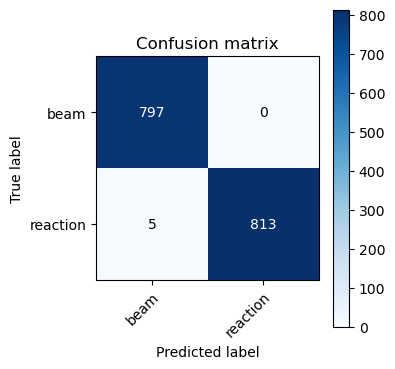

Accuracy: 0.9969040247678018
F1-score: 0.996934396076027
MCC: 0.9938265564282749
Confusion matrix for validation set:



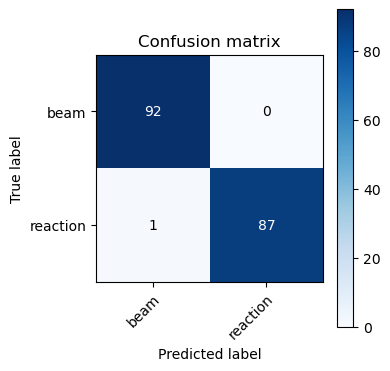

Accuracy: 0.9944444444444445
F1-score: 0.9942857142857142
MCC: 0.9889417905532354
[[92  0]
 [ 1 87]]


In [24]:
from sklearn.metrics import classification_report
from sklearn import svm

#Simplest method
#SVM = svm.SVC(kernel='rbf') #other options (poly,sigmoid,linear)
#SVM.fit(xSimple_train_stsc,Labels_train)

#SVM_pred_train = SVM.predict(xSimple_train_stsc)
#SVM_pred_val = SVM.predict(xSimple_val_stsc)


#Using grid search

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'degree': [2,3,4], 'coef0': [0.,0.001,0.01,0.1,1,10]},
                   {'kernel': ['sigmoid'], 'C': [1, 10, 100, 1000], 'coef0': [0.,0.001,0.01,0.1,1,10]}]

#select a metric to choose best SVM (comment one or the other)

#score = 'precision'
score = 'recall'


print("# Tuning hyper-parameters for %s" % score)
print()

SVM = GridSearchCV(
    svm.SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score
)
SVM.fit(xSimple_train_stsc,Labels_train)

print("Best parameters set found on training set for %s:" % score)
print()
print(SVM.best_params_)
print()
print("Grid scores on training set:")
print()
means = SVM.cv_results_['mean_test_score']
stds = SVM.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, SVM.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()

SVM_pred_train = SVM.predict(xSimple_train_stsc)
SVM_pred_val = SVM.predict(xSimple_val_stsc)

accuracy_train = accuracy_score(Labels_train, SVM_pred_train)
confmat_train = confusion_matrix(Labels_train, SVM_pred_train)
f1_train = f1_score(Labels_train, SVM_pred_train)
mcc_train = matthews_corrcoef(Labels_train, SVM_pred_train)

accuracy = accuracy_score(Labels_val, SVM_pred_val)
confmat = confusion_matrix(Labels_val, SVM_pred_val)
f1 = f1_score(Labels_val, SVM_pred_val)
mcc = matthews_corrcoef(Labels_val, SVM_pred_val)

print("Confusion matrix for training set:\n")
plot_confusion_matrix(Labels_train, SVM_pred_train, ["beam","reaction"])
print("Accuracy:", accuracy_train)
print("F1-score:", f1_train)
print("MCC:", mcc_train)

print("Confusion matrix for validation set:\n")
plot_confusion_matrix(Labels_val, SVM_pred_val, ["beam","reaction"])
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("MCC:", mcc)
print(confmat)


### DEMOCRACY
Here we let each method (linear regression, DNN, K-means and Random Forest) vote for the classification

Confusion matrix for training set:



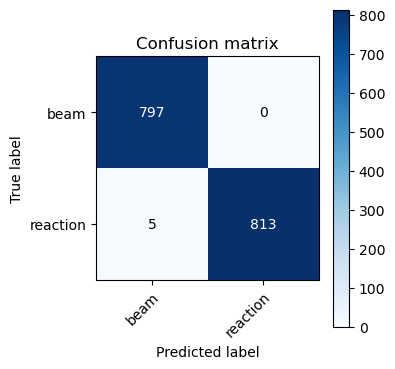

Accuracy: 0.9969040247678018
F1-score: 0.996934396076027
MCC: 0.9938265564282749
[1 0 1 ... 1 0 1]
Confusion matrix for validation set:



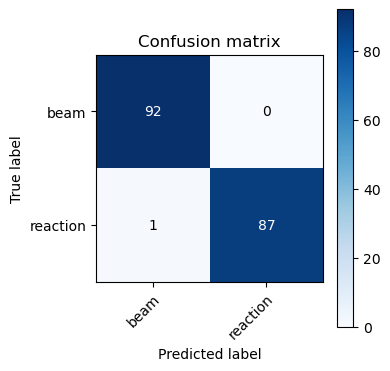

Accuracy: 0.9944444444444445
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


In [25]:
#TotalVotesTrain = DNN_pred_train + KM_pred_train + LR_pred_train + RFC_pred_train
#TotalVotesVal = DNN_pred_val + KM_pred_val + LR_pred_val + RFC_pred_val
Vote_pred_train = np.zeros(len(DNN_pred_train ))
Vote_pred_val = np.zeros(len(DNN_pred_val ))

for i in range(len(DNN_pred_train)):
    TotalVotesTrain = DNN_pred_train[i] + KM3_pred_train[i] + LR_pred_train[i] + RFC_pred_train[i] + SVM_pred_train[i]
    if TotalVotesTrain > 2:
        Vote_pred_train[i] = 1
    else:
        Vote_pred_train[i] = 0
for i in range(len(DNN_pred_val)):
    TotalVotesVal = DNN_pred_val[i] + KM3_pred_val[i] + LR_pred_val[i] + RFC_pred_val[i] + SVM_pred_val[i]
    if TotalVotesVal > 2:
        Vote_pred_val[i] = 1
    else:
        Vote_pred_val[i] = 0
    
accuracy_train = accuracy_score(Labels_train, Vote_pred_train)
confmat_train = confusion_matrix(Labels_train, Vote_pred_train)
f1_train = f1_score(Labels_train, Vote_pred_train)
mcc_train = matthews_corrcoef(Labels_train, Vote_pred_train)

accuracy = accuracy_score(Labels_val, Vote_pred_val)
confmat = confusion_matrix(Labels_val, Vote_pred_val)
f1 = f1_score(Labels_val, Vote_pred_val)
mcc = matthews_corrcoef(Labels_val, Vote_pred_val)

print("Confusion matrix for training set:\n")
plot_confusion_matrix(Labels_train, Vote_pred_train, ["beam","reaction"])
print("Accuracy:", accuracy_train)
print("F1-score:", f1_train)
print("MCC:", mcc_train)
print(RFC_pred_train)

print("Confusion matrix for validation set:\n")
plot_confusion_matrix(Labels_val, Vote_pred_val, ["beam","reaction"])
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("MCC:", mcc)




### Misclassified Event (training set)
Here we find and plot all events in the training set that were misclassified using the democratic voting above

[1711  499 1237  280 1098]


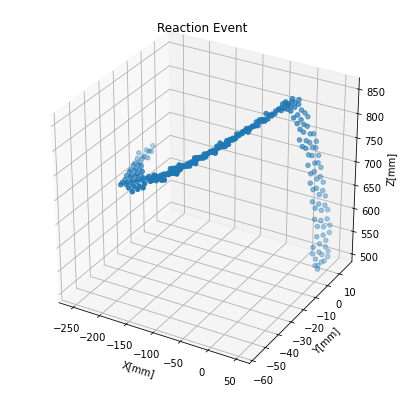

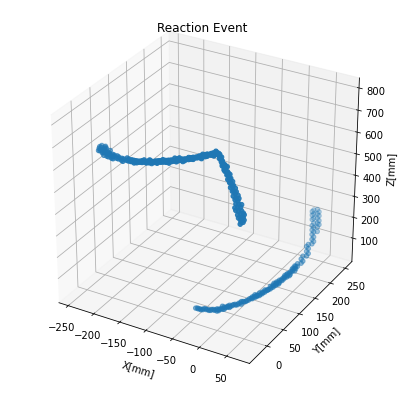

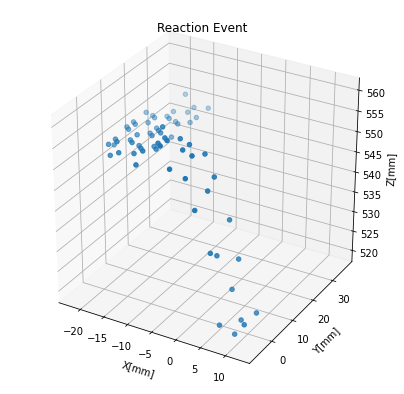

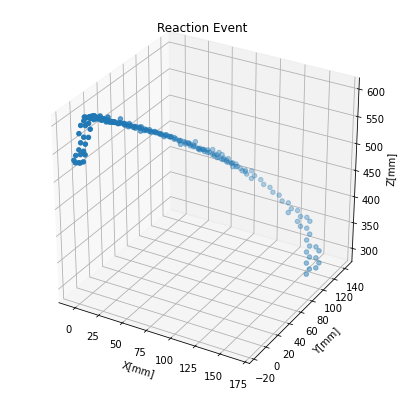

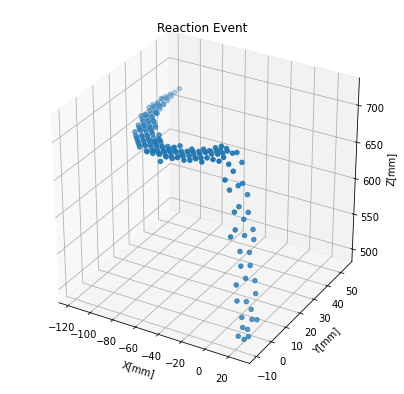

In [26]:
misclassified_events_train = train_idx[Labels_train != Vote_pred_train]

print(misclassified_events_train)

for i in(misclassified_events_train):
    plot_3d_event(AllData,Labels,i)

In [27]:
#data_origin = 'https://github.com/NuclearTalent/MachineLearningECT/raw/master/doc/ProjectsExercises/2020/ProjectAT/pdf/Mg22_alphaalpha_digiSim.h5'

#data_path = tf.keras.utils.get_file('Mg22_alphaalpha_digiSim.h5', origin=data_origin)
#h5 = h5py.File(data_path, 'r')